In [1]:
import pandas as pd
import torch

#grab data from working directory
main_data = pd.read_csv('data/data.csv')
training_data = pd.read_csv('data/training_data.csv')
validation_data = pd.read_csv('data/validation_data.csv')

In [2]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Constant to control how frequently we print train loss

print('using device:', device)

using device: cuda:0


In [3]:
# prompt: write 2 data preprocessing functions
# the first one filters out all rows that have an empty 'problem_tags' column or have the problem_tags column include "*specialproblem". it also filters out all rows that have empty problem_statement columns
# the second function will split the problem_tags column and split it into two columns. the first resulting column will just be the original problem_tags column and the second resulting column will be rating.
# the problem tags column is originally a comma seperated list and should include some value that looks like *2400 or *2300 or *900, these values are ratings. there should be only one of them, take the rating value and put it in the rating column. if there is a problem with no rating value in its 'problem_tags' column it should be filtered out

def preprocess_data_1(df):
  """
  Filters out rows with empty 'problem_tags' or 'problem_statement' columns,
  and rows where 'problem_tags' contains '*specialproblem'.
  """
  df = df.dropna(subset=['problem_tags', 'problem_statement'])
  df = df[~df['problem_tags'].str.contains(r"\*specialproblem", na=False)]
  return df

def preprocess_data_2(df):
  """
  Splits the 'problem_tags' column into two columns: 'problem_tags' (original)
  and 'rating'. Extracts the rating value from the 'problem_tags' column if
  it exists, otherwise filters out the row.
  """
  def extract_rating(tags):
    if isinstance(tags, str):
      for tag in tags.split(','):
        if '*' in tag and tag.replace('*', '').isdigit():
          return int(tag.replace('*', ''))
    return None

  df.loc[:, 'rating'] = df['problem_tags'].apply(extract_rating)

  #drop rows with no rating
  df = df.dropna(subset=['rating'])

  for i in range(len(df)):
    good_tags = []
    for tag in df.iloc[i]['problem_tags'].split(','):
      if '*' not in tag and tag.split():
        good_tags.append(tag)
    df.loc[df.index[i], 'problem_tags'] = ','.join(good_tags)

  #drop problems with empty string for tags
  df = df[df['problem_tags'] != '']

  return df

main_data = preprocess_data_1(main_data)
main_data = preprocess_data_2(main_data)
training_data = preprocess_data_1(training_data)
training_data = preprocess_data_2(training_data)
validation_data = preprocess_data_1(validation_data)
validation_data = preprocess_data_2(validation_data)

In [4]:

n = 25  # Hyperparameter for the number of most frequent tags

all_tags = []
for tags in main_data['problem_tags'].dropna():
    all_tags.extend(tags.split(','))

from collections import Counter

tag_counts = Counter(all_tags)
most_frequent_tags = set([tag for tag, count in tag_counts.most_common(n)])
index_to_tag = {i: tag for i, tag in enumerate(most_frequent_tags)}
tag_to_index = {tag: i for i, tag in index_to_tag.items()}
print(f"The {n} most frequent tags are: {most_frequent_tags}")

The 25 most frequent tags are: {'hashing', 'dp', 'numbertheory', 'twopointers', 'math', 'bruteforce', 'probabilities', 'strings', 'dfsandsimilar', 'constructivealgorithms', 'binarysearch', 'greedy', 'trees', 'shortestpaths', 'geometry', 'interactive', 'bitmasks', 'games', 'divideandconquer', 'combinatorics', 'datastructures', 'graphs', 'implementation', 'dsu', 'sortings'}


In [5]:
from sklearn.utils import resample

desired_samples = 1000
threshold = 999

# Identify less frequent tags
less_frequent_tags = [tag for tag in most_frequent_tags if tag_counts[tag] < threshold]  # Set your desired threshold

# Oversample data points with less frequent tags
oversampled_data = []
for tag in less_frequent_tags:
    tag_data = training_data[training_data['problem_tags'].str.contains(tag)]
    oversampled_tag_data = resample(tag_data, replace=True, n_samples=desired_samples, random_state=42)  # Adjust desired_samples
    oversampled_data.append(oversampled_tag_data)

# Combine oversampled data with original data
training_data = pd.concat([training_data] + oversampled_data)

In [6]:
# prompt: what percent of problems use a tag found in the n most common ?

problems_with_top_n_tags = 0
total_problems = len(main_data)

for tags in main_data['problem_tags'].dropna():
  if isinstance(tags, str):
    for tag in tags.split(','):
      if tag in most_frequent_tags:
        problems_with_top_n_tags += 1
        break  # Only count the problem once if it has at least one top-n tag

percentage = (problems_with_top_n_tags / total_problems) * 100
print(f"Percentage of problems with at least one of the top {n} tags: {percentage:.2f}%")

Percentage of problems with at least one of the top 25 tags: 99.45%


In [ ]:
# prompt: make a histogram for the ratings a bar graph for the frequency of each tag in the top n

import matplotlib.pyplot as plt
from collections import Counter

# Assuming 'main_data' and 'most_frequent_tags' are defined as in your previous code

# Histogram for ratings
plt.figure(figsize=(10, 5))
plt.hist(training_data['rating'], bins=10, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Problem Ratings')
plt.show()

print(len(training_data))

# Bar graph for tag frequency
tag_frequencies = Counter([tag for tags in training_data['problem_tags'].dropna() for tag in tags.split(',') if tag in most_frequent_tags])

plt.figure(figsize=(15, 5))
plt.bar(tag_frequencies.keys(), tag_frequencies.values())
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title(f'Frequency of Top {n} Tags')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


#bar graph for how many problems have k different tags in the top n
tag_counts = {}
for tags in training_data['problem_tags'].dropna():
  if isinstance(tags, str):
    tag_count = len(tags.split(','))
    if tag_count in tag_counts:
      tag_counts[tag_count] += 1
    else:
      tag_counts[tag_count] = 1

plt.figure(figsize=(10, 5))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.title(f'Frequency of Number of Tags')
print(len(training_data))

In [8]:
# prompt: now make a function that takes  the string from problem tags, and returns a pytorch vector of floats length n, where a[i] is 1 iff the ith most frequent problem tag is in the list
# also make a function that takes a rating and computes its zscore when the mean rating is 1500 and the standard deviation is 300
# make an inverse of that function as well
from transformers import BertTokenizer
def problem_tags_to_vector(tags_string, most_frequent_tags, n):
  """
  Converts a string of problem tags to a PyTorch vector of length n.

  Args:
    tags_string: A string of problem tags separated by commas.
    most_frequent_tags: A set of the n most frequent problem tags.
    n: The length of the vector.

  Returns:
    A PyTorch vector of floats, where a[i] is 1 if the ith most frequent
    problem tag is present in the tags_string, and 0 otherwise.
  """
  if not isinstance(tags_string, str):
    return torch.zeros(n)
  tags = set(tags_string.split(','))
  vector = [1.0 if tag in tags else 0.0 for tag in most_frequent_tags]
  return torch.tensor(vector, dtype=torch.float32)

def rating_to_zscore(rating):
  """Computes the z-score of a rating."""
  mean_rating = 1500
  std_rating = 300
  return (rating - mean_rating) / std_rating

def zscore_to_rating(zscore):
  """Computes the rating from a z-score."""
  mean_rating = 1500
  std_rating = 300
  return (zscore * std_rating) + mean_rating

MAXLEN = 512
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_text(text):
  return tokenizer(text, padding='max_length', truncation=True, max_length=MAXLEN)


#TODO
#MOVE THIS TO A MORE SENSIBLE AREA

/common/home/nt406/Desktop/cf-classification/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from transformers import BertModel
from torch.utils.data import Dataset
import torch.nn.init as init
import torch.nn as nn

class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.bert = BertModel.from_pretrained('prajjwal1/bert-small')
        self.rating_classifier = nn.Linear(768, 1)  # For regression or binary classification
        self.tag_classifier = nn.Linear(768, n)  # Multi-label classification

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        rating_pred = self.rating_classifier(pooled_output)
        tag_pred = self.tag_classifier(pooled_output)
        return rating_pred, tag_pred

class TagModel(nn.Module):
    def __init__(self):
        super(TagModel, self).__init__()
        self.bert = BertModel.from_pretrained('prajjwal1/bert-small')
        self.dropout = nn.Dropout(0.4)  # Experiment with dropout rate (e.g., 0.1-0.5)
        self.tag_classifier = nn.Sequential(
            nn.Linear(512, n),  # Your original linear layer
            nn.LayerNorm(n)   # Layer Normalization layer
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)  # Apply dropout
        tag_pred = self.tag_classifier(pooled_output)
        return tag_pred

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, ratings, tags, device):
        self.input_ids = input_ids.to(device)
        self.attention_mask = attention_mask.to(device)
        self.ratings = ratings.to(device)
        self.tags = tags.to(device)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.ratings[idx], self.tags[idx]

In [10]:
from torch.utils.data import DataLoader, TensorDataset

texts = training_data['problem_statement'].tolist()
encodings = tokenizer(texts, truncation=True, padding=True, max_length=MAXLEN)

tags = training_data['problem_tags'].tolist()
tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in tags]

ratings = training_data['rating'].tolist()
ratings = [rating_to_zscore(rating) for rating in ratings]

input_ids = torch.tensor(encodings['input_ids'])
attention_mask = torch.tensor(encodings['attention_mask'])
ratings = torch.tensor(ratings, dtype=torch.float32)

tags = torch.stack(tags)

#validation stuff
val_texts = validation_data['problem_statement'].tolist()
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAXLEN)

val_tags = validation_data['problem_tags'].tolist()
val_tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in val_tags]

val_ratings = validation_data['rating'].tolist()
val_ratings = [rating_to_zscore(rating) for rating in val_ratings]

val_input_ids = torch.tensor(val_encodings['input_ids'])
val_attention_mask = torch.tensor(val_encodings['attention_mask'])
val_ratings = torch.tensor(val_ratings, dtype=torch.float32)

val_tags = torch.stack(val_tags)


bsz = 32
val_dataset = CustomDataset(val_input_ids, val_attention_mask, val_ratings, val_tags, device)
val_loader = DataLoader(val_dataset, batch_size=bsz, shuffle=True)
dataset = CustomDataset(input_ids, attention_mask, ratings, tags, device)
loader = DataLoader(dataset, batch_size=bsz, shuffle=True)

In [11]:
# prompt: write a function that runs the model on the validation data set, and determines its accuracy on each specific tag. Returns a vector length n with the % accuracy for each tag. The model uses a threshold of 0.5 for classification. remember to apply sigmoid to map the output layer to [0,1]

def evaluate_tag_accuracy(model, val_loader, device, n):
  """
  Evaluates the model's accuracy on the validation dataset for each tag.

  Args:
    model: The trained model.
    val_loader: The DataLoader for the validation dataset.
    device: The device to run the model on (e.g., 'cuda' or 'cpu').
    n: The number of tags.

  Returns:
    A list of floats, representing the accuracy for each tag.
  """

  model.eval()  # Set the model to evaluation mode
  tag_correct_counts = [0] * n
  tag_total_counts = [0] * n
  avg_loss = 0
  with torch.no_grad():
    for batch in val_loader:
      input_ids, attention_mask, _, true_tags = batch
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      true_tags = true_tags.to(device)


      tag_pred = model(input_ids, attention_mask)
      loss = nn.BCEWithLogitsLoss()(tag_pred, true_tags)
      avg_loss += loss.item()
      tag_pred = torch.sigmoid(tag_pred)  # Apply sigmoid to get probabilities in [0,1]

      predicted_tags = (tag_pred > 0.5).float()

      for i in range(n):
        tag_correct_counts[i] += (predicted_tags[:, i] == true_tags[:, i]).sum().item()
        tag_total_counts[i] += true_tags.shape[0]
  avg_loss /= len(val_loader)

  tag_accuracies = []
  for i in range(n):
    if tag_total_counts[i] > 0:
      tag_accuracies.append(tag_correct_counts[i] / tag_total_counts[i] * 100)
    else:
      tag_accuracies.append(0.0)

  return (avg_loss,tag_accuracies)

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import torch.optim as optim
from tqdm import tqdm

total_losses = []
val_losses = []
val_acc = []

model = TagModel()
model.apply(init_weights)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
model.train()

EPOCHS = 30
for epoch in range(EPOCHS):
    loop = tqdm(loader, leave=True) # wrap the dataloader with tqdm
    for batch_idx, batch in enumerate(loop):
        input_ids, attention_mask, rating_labels, tag_labels = batch

        optimizer.zero_grad()
        tag_pred = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = nn.BCEWithLogitsLoss()(tag_pred, tag_labels)

        total_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch + 1}/{EPOCHS}]")
        loop.set_postfix(tag_loss=loss.item())

    print(f"Epoch {epoch + 1} completed.")
    model.eval()
    avg_loss, tag_accuracies = evaluate_tag_accuracy(model, val_loader, device, n)
    val_losses.append(avg_loss)
    val_acc.append(tag_accuracies)
    print(f"Validation Loss: {avg_loss}")
    print(f"Tag Accuracies: {tag_accuracies}")
    model.train()


In [ ]:
# prompt: make 3 charts, one the training loss over time, one the validation loss for each epoch and another with the accuracy rates of each category over each epoch label the categories by their true names found in index_to_tag

# Plot training loss over time
plt.figure(figsize=(10, 5))
plt.plot(total_losses)
plt.xlabel('Batch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time')
plt.show()

# Plot validation loss for each epoch
plt.figure(figsize=(10, 5))
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time')
plt.show()

# Plot accuracy rates of each category over epochs
plt.figure(figsize=(10, 5))
for i in range(n):
  accuracies = [epoch_accuracies[i] for epoch_accuracies in val_acc]
  plt.plot(accuracies, label=index_to_tag[i])

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Each Category Over Time')
plt.legend()
plt.show()

Average Accuracy for Epoch 1: 72.54%
Average Accuracy for Epoch 2: 76.41%
Average Accuracy for Epoch 3: 79.72%
Average Accuracy for Epoch 4: 82.03%
Average Accuracy for Epoch 5: 83.29%
Average Accuracy for Epoch 6: 84.69%
Average Accuracy for Epoch 7: 85.64%
Average Accuracy for Epoch 8: 86.04%
Average Accuracy for Epoch 9: 86.86%
Average Accuracy for Epoch 10: 86.73%
Average Accuracy for Epoch 11: 86.94%
Average Accuracy for Epoch 12: 87.10%
Average Accuracy for Epoch 13: 87.50%
Average Accuracy for Epoch 14: 87.54%
Average Accuracy for Epoch 15: 87.93%
Average Accuracy for Epoch 16: 88.16%
Average Accuracy for Epoch 17: 88.44%
Average Accuracy for Epoch 18: 88.41%
Average Accuracy for Epoch 19: 88.51%
Average Accuracy for Epoch 20: 88.38%
Average Accuracy for Epoch 21: 88.71%
Average Accuracy for Epoch 22: 88.84%
Average Accuracy for Epoch 23: 88.93%
Average Accuracy for Epoch 24: 88.89%
Average Accuracy for Epoch 25: 88.90%
Average Accuracy for Epoch 26: 88.87%
Average Accuracy for 

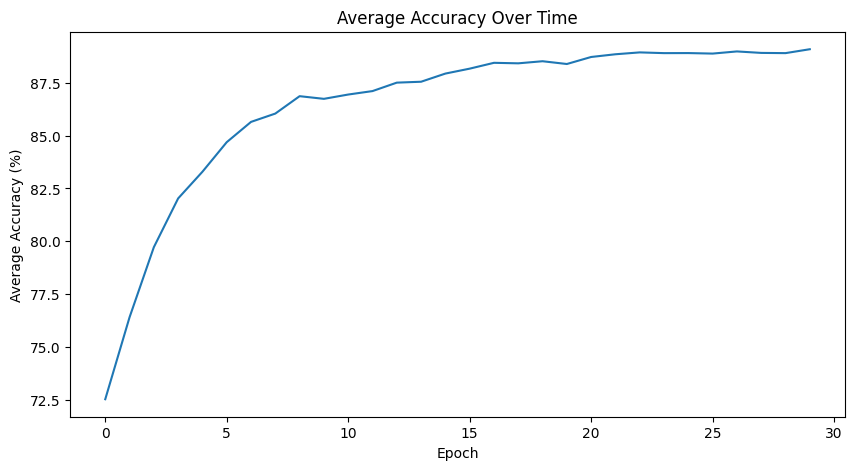

In [14]:
# prompt: now make a new char just for the average accuracy

# Calculate and print the average accuracy across all tags for each epoch
for epoch in range(EPOCHS):
    avg_epoch_accuracy = sum(val_acc[epoch]) / len(val_acc[epoch])
    print(f"Average Accuracy for Epoch {epoch + 1}: {avg_epoch_accuracy:.2f}%")

# Plot the average accuracy over epochs
plt.figure(figsize=(10, 5))
avg_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in val_acc]
plt.plot(avg_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy (%)')
plt.title('Average Accuracy Over Time')
plt.show()